The two things I wanted to focus on were how many sessions ended in a sale, and the amount of the two types of customer coming to browse the site. Both are heavily imbalanced which means that when evaluating a model we cannot just rely on the model’s accuracy, since it could just dump every data point into the majority class and still give ~80% accuracy. It wouldn’t be able to adapt well to new data either. 

I begin by importing everything I'll need for the notebook, and load in the dataset and split it on what we want classified. The first category I'll focus on is Revenue.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

In [2]:
df = pd.read_csv('df_new.csv')
X = df.loc[:, df.columns != 'Revenue']
y = df['Revenue']

To prevent data leakage that will interfere with the model's ability to adapt to unseen data, I make sure to do this split before using any sort of sampling technique.

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=1)

Then, I extract all of the columns that are numeric and scale them so that our results aren't skewed by highly differing values. Below that, I one hot encode with pandas' get_dummies function on the categorical data so that our model can actually use that data when it's trying to classify.

In [4]:
num_cols = X.columns[X.dtypes.apply(lambda c: np.issubdtype(c, np.number))]

scaler = MinMaxScaler().fit(X_train[num_cols])
X_train[num_cols] = scaler.transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [5]:
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

Here I manually changed the trues and falses for the same reason we one hot encoded above.

In [6]:
replace_dict = {True: 1, False: 0}
X_train = X_train.replace(replace_dict)
X_test = X_test.replace(replace_dict)

Now that all of my data is imported and ready to model, I'm going to start with using classification models on the over sampled data. 

In [7]:
sm = SMOTE(random_state=42)
X_trainOS, y_trainOS = sm.fit_resample(X_train, y_train)
Counter(y_trainOS)

Counter({False: 8307, True: 8307})

              precision    recall  f1-score   support

       False       0.96      0.92      0.94      2115
        True       0.60      0.74      0.66       351

    accuracy                           0.89      2466
   macro avg       0.78      0.83      0.80      2466
weighted avg       0.91      0.89      0.90      2466



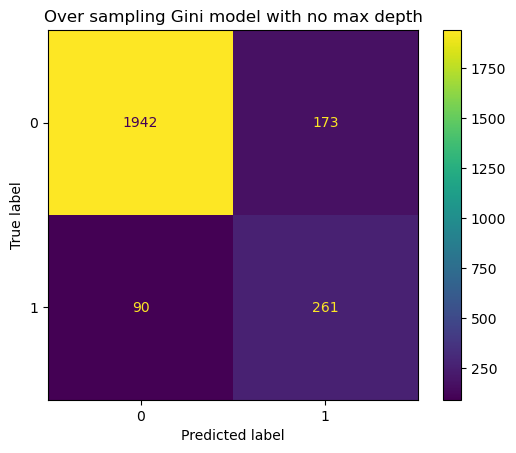

In [8]:
clf = RandomForestClassifier(criterion='gini', random_state=2)
clf.fit(X_trainOS, y_trainOS)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
pl = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(pl)
disp.plot()
plt.title('Over sampling Gini model with no max depth')
plt.show()

The top left and bottom right squares are what our model classified correctly. This model seems to have done pretty well; to make sure I'm interpreting this correctly I calculate the AUC score and visualize the ROC curve.

When calculating the AUC score, we're hoping for a value close to 1, and when visualizing the ROC curve we're hoping for an orange line making a right angle above the blue line. Let's take a look at what we have:

0.9330996208064766


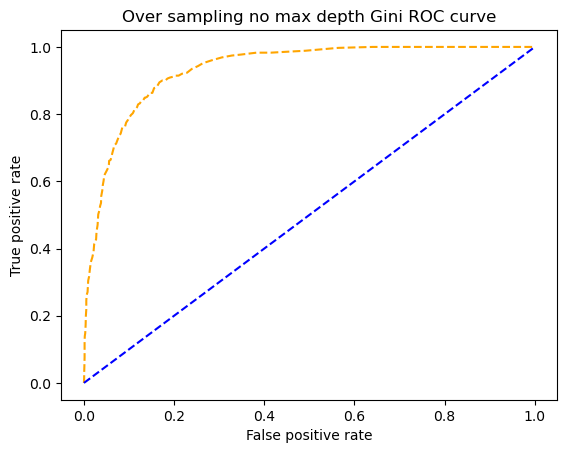

In [9]:
pred_prob = clf.predict_proba(X_test)
fpr, tpr, thresh = roc_curve(y_test, pred_prob[:,1])

random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs)

auc_score = roc_auc_score(y_test, pred_prob[:,1])
print(auc_score)


plt.plot(fpr, tpr, linestyle='--', color='orange')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.title('Over sampling no max depth Gini ROC curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

Our AUC score is .93, and our ROC curve is getting close to the right angle that we desire. So my interpretation of the confusion matrix above was accurate - this model did very well in classifying the data!

              precision    recall  f1-score   support

       False       0.97      0.88      0.92      2115
        True       0.54      0.81      0.65       351

    accuracy                           0.87      2466
   macro avg       0.75      0.85      0.79      2466
weighted avg       0.91      0.87      0.88      2466



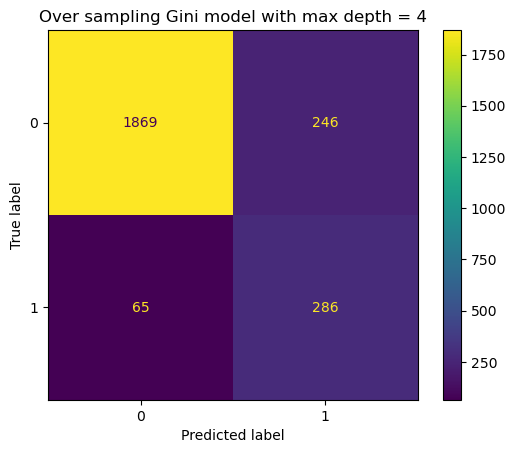

In [10]:
clf = RandomForestClassifier(criterion='gini', max_depth=4, random_state=2)
clf.fit(X_trainOS, y_trainOS)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
pl = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(pl)
disp.plot()
plt.title('Over sampling Gini model with max depth = 4')
plt.show()

Here I specified a max depth to see if making a cutting off point for the decision trees would help the model classify better. It did classify true positives better, but it did worse on classifying true negatives. Just looking at this I'm not sure if it's any better or worse than the previous model, so I take a look at the AUC score and ROC curve.

0.9089019552376525


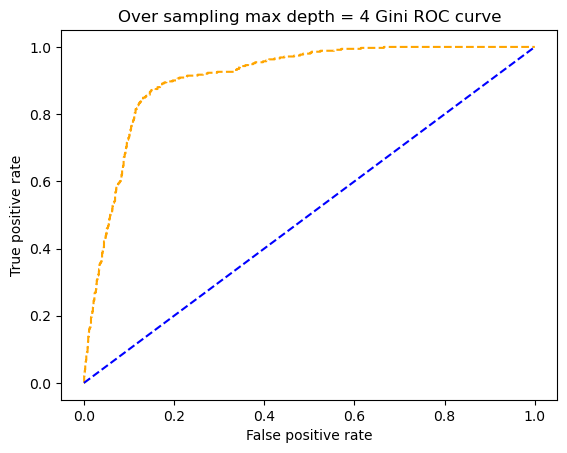

In [11]:
pred_prob = clf.predict_proba(X_test)
fpr, tpr, thresh = roc_curve(y_test, pred_prob[:,1])

random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs)

auc_score = roc_auc_score(y_test, pred_prob[:,1])
print(auc_score)


plt.plot(fpr, tpr, linestyle='--', color='orange')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.title('Over sampling max depth = 4 Gini ROC curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

Our AUC score dropped by about .03, so this model did do worse overall, though just barely. I do like that it classified the true positives better than the previous model.

The Random Forest that wasn't given a max depth performed better in all aspects - the f1 and the auc score were higher by several points. The entropy model shows similar results:

              precision    recall  f1-score   support

       False       0.96      0.91      0.94      2115
        True       0.60      0.76      0.67       351

    accuracy                           0.89      2466
   macro avg       0.78      0.84      0.80      2466
weighted avg       0.91      0.89      0.90      2466



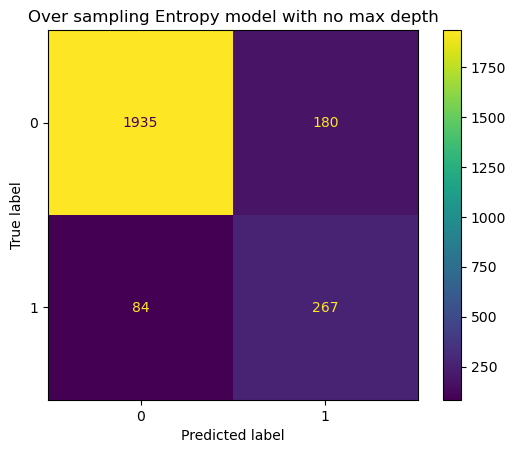

In [12]:
clf = RandomForestClassifier(criterion='entropy', random_state=2)
clf.fit(X_trainOS, y_trainOS)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
pl = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(pl)
disp.plot()
plt.title('Over sampling Entropy model with no max depth')
plt.show()

0.9343193711988038


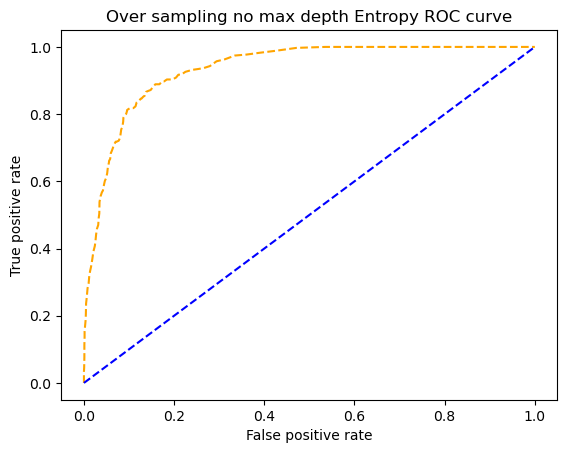

In [13]:
pred_prob = clf.predict_proba(X_test)
fpr, tpr, thresh = roc_curve(y_test, pred_prob[:,1])

random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs)

auc_score = roc_auc_score(y_test, pred_prob[:,1])
print(auc_score)


plt.plot(fpr, tpr, linestyle='--', color='orange')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.title('Over sampling no max depth Entropy ROC curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

AUC score of .93 and it did better in classifying true positives. This model seems the most promising so far. Just to see a full comparison I specified the max depth to see if that behaved similar to the gini model.

              precision    recall  f1-score   support

       False       0.97      0.88      0.92      2115
        True       0.54      0.81      0.65       351

    accuracy                           0.87      2466
   macro avg       0.75      0.85      0.79      2466
weighted avg       0.91      0.87      0.88      2466



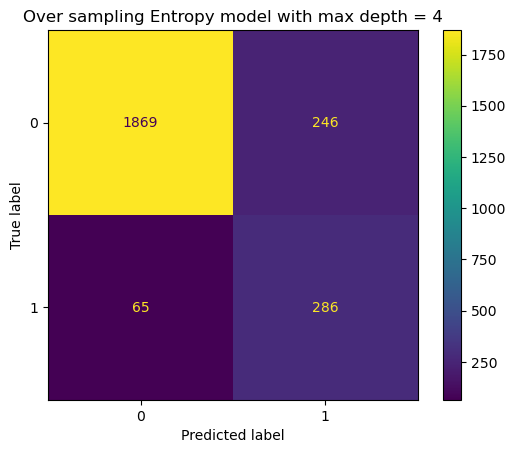

In [14]:
clf = RandomForestClassifier(criterion='entropy', max_depth=4, random_state=2)
clf.fit(X_trainOS, y_trainOS)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
pl = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(pl)
disp.plot()
plt.title('Over sampling Entropy model with max depth = 4')
plt.show()

0.9094326914657883


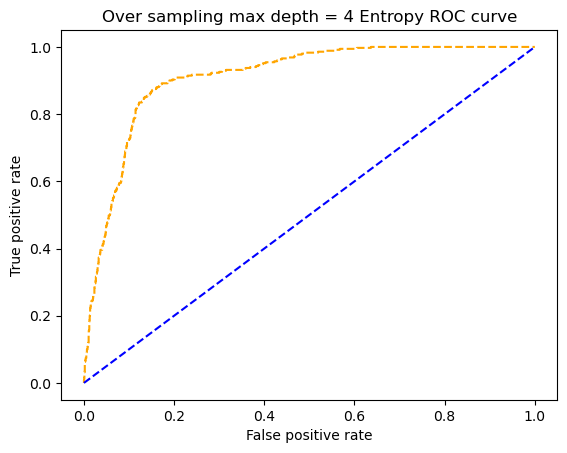

In [15]:
pred_prob = clf.predict_proba(X_test)
fpr, tpr, thresh = roc_curve(y_test, pred_prob[:,1])

random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs)

auc_score = roc_auc_score(y_test, pred_prob[:,1])
print(auc_score)


plt.plot(fpr, tpr, linestyle='--', color='orange')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.title('Over sampling max depth = 4 Entropy ROC curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

This model actually classified exactly the same way the gini model did with a specified max depth. The AUC scores are also incredibly close, only being off by about .001.

Just so I don't limit myself to Random Forests, I also checked out Ada and Gradient boosting to see how those fared:

              precision    recall  f1-score   support

       False       0.95      0.92      0.94      2115
        True       0.61      0.73      0.66       351

    accuracy                           0.89      2466
   macro avg       0.78      0.82      0.80      2466
weighted avg       0.90      0.89      0.90      2466



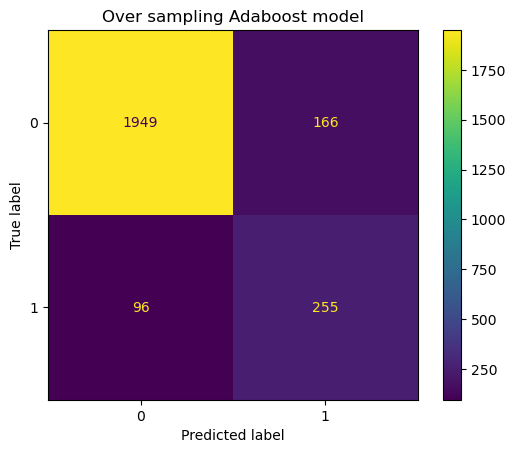

In [16]:
clf = AdaBoostClassifier(n_estimators=100, random_state=3)
clf.fit(X_trainOS, y_trainOS)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
pl = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(pl)
disp.plot()
plt.title('Over sampling Adaboost model')
plt.show()

0.9142133586578032


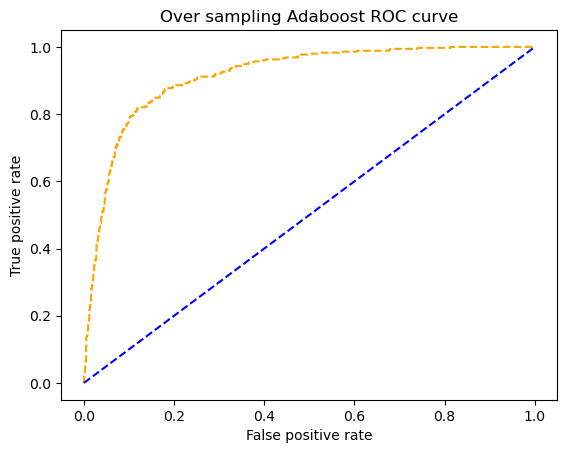

In [17]:
pred_prob = clf.predict_proba(X_test)
fpr, tpr, thresh = roc_curve(y_test, pred_prob[:,1])

random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs)

auc_score = roc_auc_score(y_test, pred_prob[:,1])
print(auc_score)


plt.plot(fpr, tpr, linestyle='--', color='orange')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.title('Over sampling Adaboost ROC curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

Adaboost did the best at classifying true negatives (only marginally, though) and it also misclassified false negatives more than any other model. It does score higher than the entropy and gini model with a specified max depth, but again - only marginally. 

              precision    recall  f1-score   support

       False       0.96      0.92      0.94      2115
        True       0.60      0.76      0.67       351

    accuracy                           0.89      2466
   macro avg       0.78      0.84      0.80      2466
weighted avg       0.91      0.89      0.90      2466



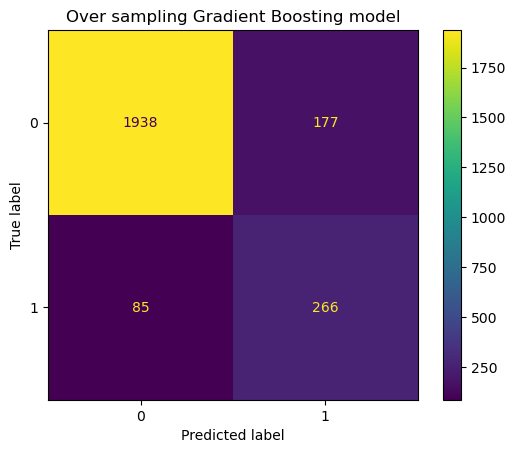

In [18]:
clf = GradientBoostingClassifier(n_estimators=100, criterion='friedman_mse', random_state=4)
clf.fit(X_trainOS, y_trainOS)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
pl = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(pl)
disp.plot()
plt.title('Over sampling Gradient Boosting model')
plt.show()

0.9308426447906354


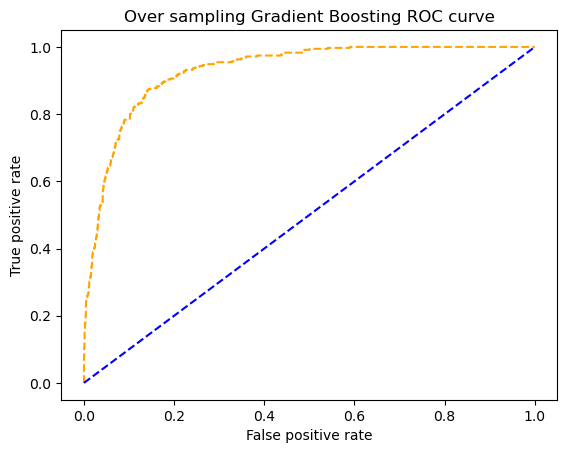

In [19]:
pred_prob = clf.predict_proba(X_test)
fpr, tpr, thresh = roc_curve(y_test, pred_prob[:,1])

random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs)

auc_score = roc_auc_score(y_test, pred_prob[:,1])
print(auc_score)


plt.plot(fpr, tpr, linestyle='--', color='orange')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.title('Over sampling Gradient Boosting ROC curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

Since adaboosting didn't perform exceptionally good or bad, I expected gradient boosting to be similar. However, it holds up well against the gini and entropy models, only scoring ~.003 below them. 

Other than the gini and entropy models with a specified max depth, all of the models here scored very closely to each other which makes it hard to pick which one is truly "the best." Gradient boosting, unspecified entropy, and unspecified gini all had an auc score of about 93% and had high f1 scores so those would definitely be my first choices.

At first when tackling this project, I only focused on these algorithms to do the classifying - but as I look back, I realize there are other algorithms I should have also considered. I quickly implement these below, starting with naive bayes:

In [20]:
mnb = MultinomialNB().fit(X_trainOS, y_trainOS)

print('score on test: ' + str(mnb.score(X_test, y_test)))
print('score on train: ' + str(mnb.score(X_trainOS, y_trainOS)))

score on test: 0.6613949716139497
score on train: 0.6795473696882147


Then I move to logistic regression:

In [21]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_trainOS, y_trainOS)

print('score on test: ' + str(lr.score(X_test, y_test)))
print('score on train: ' + str(lr.score(X_trainOS, y_trainOS)))

score on test: 0.8418491484184915
score on train: 0.827494883832912


Then K-Nearest Neighbours:

In [22]:
knn = KNeighborsClassifier().fit(X_trainOS, y_trainOS)

print('score on test: ' + str(knn.score(X_test, y_test)))
print('score on train: ' + str(knn.score(X_trainOS, y_trainOS)))

score on test: 0.7112733171127331
score on train: 0.9032141567352835


And finally, Support Vector Machine:

In [23]:
svm = LinearSVC(C=0.0001)
svm.fit(X_trainOS, y_trainOS)

print('score on test: ' + str(svm.score(X_test, y_test)))
print('score on train: ' + str(svm.score(X_trainOS, y_trainOS)))

score on test: 0.6792376317923763
score on train: 0.6367521367521367


These other classification algorithms did worse than the ensemble methods that I initally chose to test, which goes to show that my hunch to use ensemble learning was correct. Only logistic regression came close to the ensemble methods with a score of .84.

While I could stop here, I decided to undersample and use these same models to see how they would function wtih a small amount of data. If certain ones perform well when under sampling, I would consider them the most robust and my top choice for classification.

In [24]:
nm = NearMiss()
X_trainUS, y_trainUS = nm.fit_resample(X_train, y_train)
Counter(y_trainUS)

Counter({False: 1557, True: 1557})

              precision    recall  f1-score   support

       False       0.97      0.58      0.73      2115
        True       0.26      0.88      0.40       351

    accuracy                           0.63      2466
   macro avg       0.61      0.73      0.56      2466
weighted avg       0.87      0.63      0.68      2466



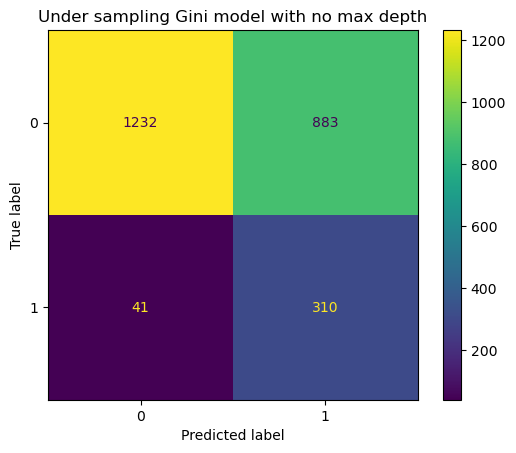

In [25]:
clf = RandomForestClassifier(criterion='gini', random_state=2)
clf.fit(X_trainUS, y_trainUS)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
pl = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(pl)
disp.plot()
plt.title('Under sampling Gini model with no max depth')
plt.show()

0.8539626733480161


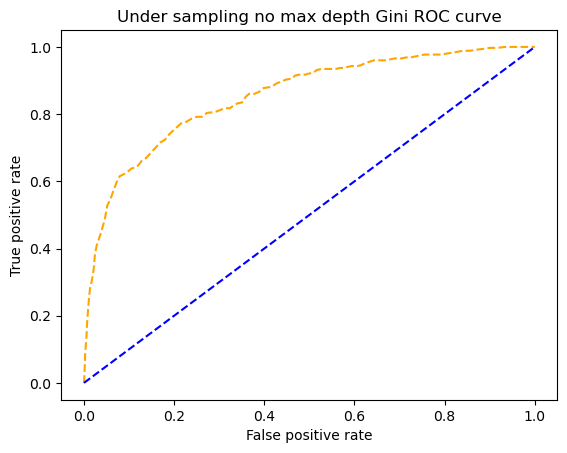

In [26]:
pred_prob = clf.predict_proba(X_test)
fpr, tpr, thresh = roc_curve(y_test, pred_prob[:,1])

random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs)

auc_score = roc_auc_score(y_test, pred_prob[:,1])
print(auc_score)


plt.plot(fpr, tpr, linestyle='--', color='orange')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.title('Under sampling no max depth Gini ROC curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

While I knew the models wouldn't do as well with the under sampling, I was surprised to see how much the model misclassified false positives. Now we move on to the model with a specified max depth, and...

              precision    recall  f1-score   support

       False       0.97      0.78      0.86      2115
        True       0.39      0.86      0.54       351

    accuracy                           0.79      2466
   macro avg       0.68      0.82      0.70      2466
weighted avg       0.89      0.79      0.82      2466



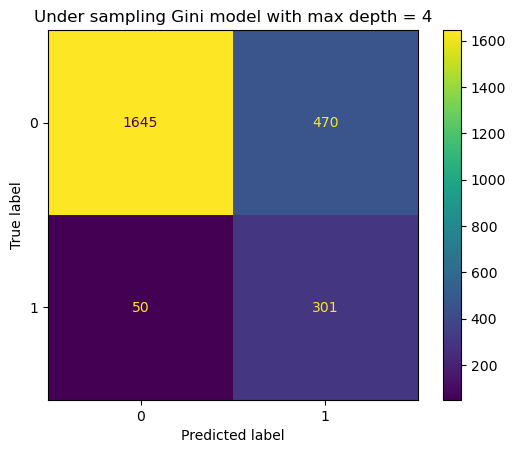

In [27]:
clf = RandomForestClassifier(criterion='gini', max_depth=4, random_state=2)
clf.fit(X_trainUS, y_trainUS)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
pl = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(pl)
disp.plot()
plt.title('Under sampling Gini model with max depth = 4')
plt.show()

0.8727485805499989


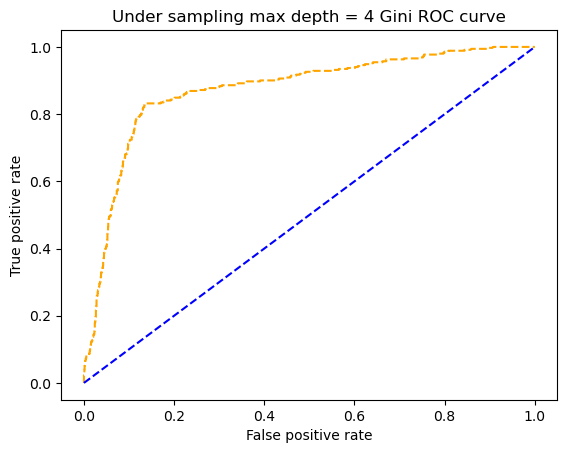

In [28]:
pred_prob = clf.predict_proba(X_test)
fpr, tpr, thresh = roc_curve(y_test, pred_prob[:,1])

random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs)

auc_score = roc_auc_score(y_test, pred_prob[:,1])
print(auc_score)


plt.plot(fpr, tpr, linestyle='--', color='orange')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.title('Under sampling max depth = 4 Gini ROC curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

Wow. It did much better in handling the false positives without much sacrifice to the true positives. It makes sense that having a specified depth would improve the score in this case - the model was most likely overfitting on the small amount of data it had before, and by trimming the trees we let the model be a little more robust to new data it encounters.

              precision    recall  f1-score   support

       False       0.97      0.63      0.76      2115
        True       0.29      0.89      0.43       351

    accuracy                           0.67      2466
   macro avg       0.63      0.76      0.60      2466
weighted avg       0.87      0.67      0.72      2466



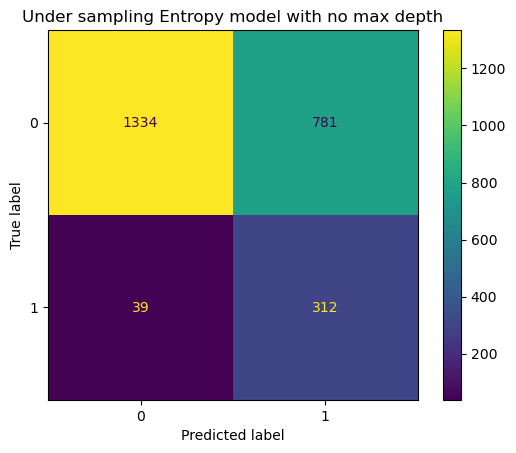

In [29]:
clf = RandomForestClassifier(criterion='entropy', random_state=2)
clf.fit(X_trainUS, y_trainUS)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
pl = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(pl)
disp.plot()
plt.title('Under sampling Entropy model with no max depth')
plt.show()

0.8610824863779947


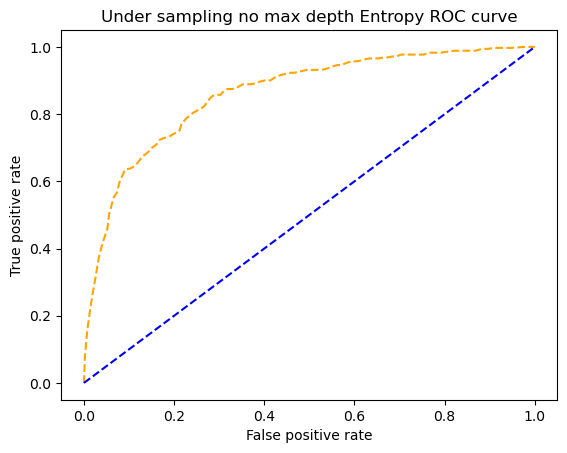

In [30]:
pred_prob = clf.predict_proba(X_test)
fpr, tpr, thresh = roc_curve(y_test, pred_prob[:,1])

random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs)

auc_score = roc_auc_score(y_test, pred_prob[:,1])
print(auc_score)


plt.plot(fpr, tpr, linestyle='--', color='orange')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.title('Under sampling no max depth Entropy ROC curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

Now this...a very nice improvement from the first gini model we did, cutting down the false positives by about 100, while also classifying true positives a little better and misclassifying false negatives a little less. The AUC score indicates that this model isn't quite as good as the gini with a specific max depth, however I think that I could pretty confidently come to the conclusion that using an entropy random forest is the best model for classifying in this scenario. Just to ensure that I'm not jumping to conclusions, I finish out with the rest of the models:

              precision    recall  f1-score   support

       False       0.97      0.80      0.87      2115
        True       0.41      0.85      0.55       351

    accuracy                           0.80      2466
   macro avg       0.69      0.83      0.71      2466
weighted avg       0.89      0.80      0.83      2466



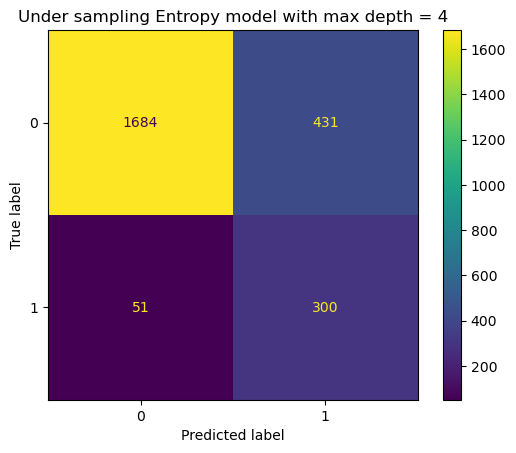

In [31]:
clf = RandomForestClassifier(criterion='entropy', max_depth=4, random_state=2)
clf.fit(X_trainUS, y_trainUS)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
pl = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(pl)
disp.plot()
plt.title('Under sampling Entropy model with max depth = 4')
plt.show()

0.8799067843985101


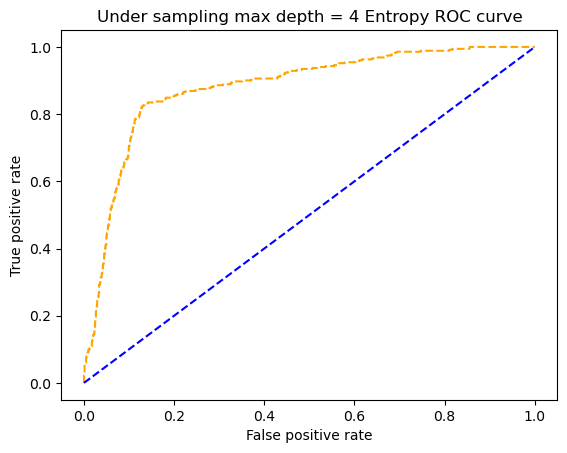

In [32]:
pred_prob = clf.predict_proba(X_test)
fpr, tpr, thresh = roc_curve(y_test, pred_prob[:,1])

random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs)

auc_score = roc_auc_score(y_test, pred_prob[:,1])
print(auc_score)


plt.plot(fpr, tpr, linestyle='--', color='orange')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.title('Under sampling max depth = 4 Entropy ROC curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

The entropy model scored higher by .007, which ultimately isn't too much of a difference but it lets me believe that using an entropy model would be the best because it's robust and able to handle a small amount of data fairly well.

              precision    recall  f1-score   support

       False       0.96      0.50      0.66      2115
        True       0.23      0.88      0.36       351

    accuracy                           0.56      2466
   macro avg       0.59      0.69      0.51      2466
weighted avg       0.86      0.56      0.62      2466



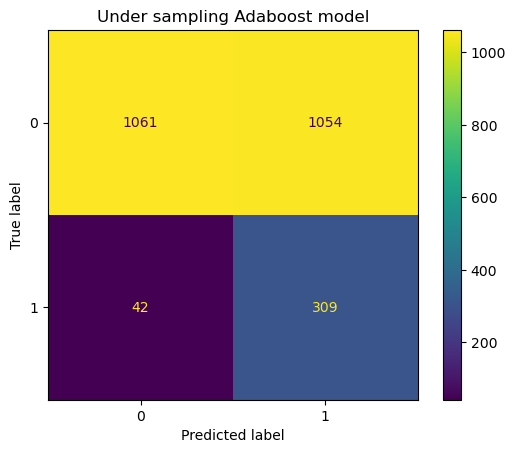

In [33]:
clf = AdaBoostClassifier(n_estimators=100, random_state=3)
clf.fit(X_trainUS, y_trainUS)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
pl = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(pl)
disp.plot()
plt.title('Under sampling Adaboost model')
plt.show()

0.6856418338687842


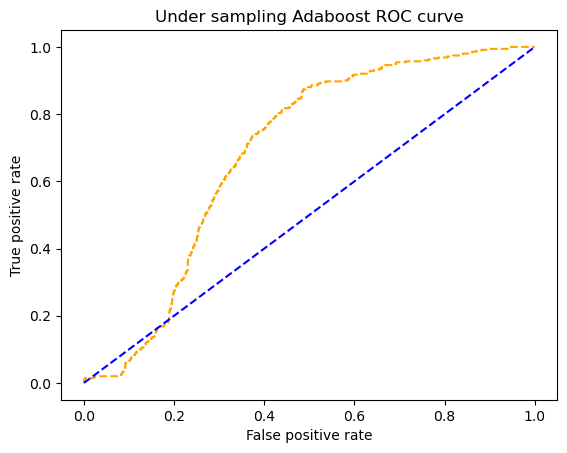

In [34]:
pred_prob = clf.predict_proba(X_test)
fpr, tpr, thresh = roc_curve(y_test, pred_prob[:,1])

random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs)

auc_score = roc_auc_score(y_test, pred_prob[:,1])
print(auc_score)


plt.plot(fpr, tpr, linestyle='--', color='orange')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.title('Under sampling Adaboost ROC curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

I think this is the most shocking to me - I didn't think Adaboosting would do this poorly, and it definitely stands out from the rest in terms of performance.

I would have expected Adaboost to perform similar to the other models thus far, especially because it's toted as an algorithm that "combine(s) multiple 'weak classifiers' into a single 'strong classifier.'" However, it seems that in this instance it may have overfit due to our data being less than ideal (small amount with high dimensionality). Keeping this in mind, I move on to our next boosting model.

              precision    recall  f1-score   support

       False       0.97      0.60      0.74      2115
        True       0.27      0.89      0.41       351

    accuracy                           0.64      2466
   macro avg       0.62      0.74      0.58      2466
weighted avg       0.87      0.64      0.69      2466



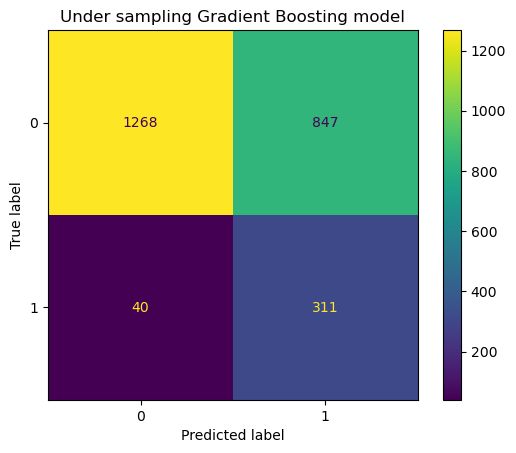

In [35]:
clf = GradientBoostingClassifier(n_estimators=100, criterion='friedman_mse', random_state=4)
clf.fit(X_trainUS, y_trainUS)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
pl = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(pl)
disp.plot()
plt.title('Under sampling Gradient Boosting model')
plt.show()

0.8306075852175143


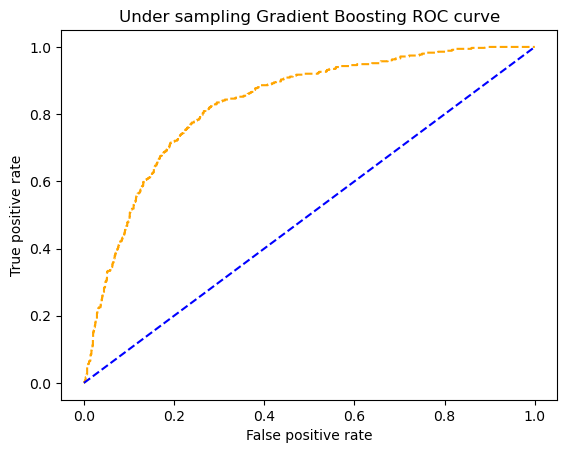

In [36]:
pred_prob = clf.predict_proba(X_test)
fpr, tpr, thresh = roc_curve(y_test, pred_prob[:,1])

random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs)

auc_score = roc_auc_score(y_test, pred_prob[:,1])
print(auc_score)


plt.plot(fpr, tpr, linestyle='--', color='orange')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.title('Under sampling Gradient Boosting ROC curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

And again, another surprise here. This model performed similarly to how the entropy and gini models without a max depth. This, to me, signals that gradient boosting is a lot more flexible when it comes to classifying data; it is able to do relatively well with an adequate amount of data and a small amount of data. 

Just to stay consistent with the over sampling that we did, I try out the other classification algorithms with the under sampled data:

In [37]:
mnb = MultinomialNB().fit(X_trainUS, y_trainUS)

print('score on test: ' + str(mnb.score(X_test, y_test)))
print('score on train: ' + str(mnb.score(X_trainUS, y_trainUS)))

score on test: 0.5547445255474452
score on train: 0.7193320488118176


In [38]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_trainUS, y_trainUS)

print('score on test: ' + str(lr.score(X_test, y_test)))
print('score on train: ' + str(lr.score(X_trainUS, y_trainUS)))

score on test: 0.5275750202757502
score on train: 0.8249839434810533


In [39]:
knn = KNeighborsClassifier().fit(X_trainUS, y_trainUS)

print('score on test: ' + str(knn.score(X_test, y_test)))
print('score on train: ' + str(knn.score(X_trainUS, y_trainUS)))

score on test: 0.5628548256285483
score on train: 0.8147077713551703


In [40]:
svm = LinearSVC(C=0.0001)
svm.fit(X_trainUS, y_trainUS)

print('score on test: ' + str(svm.score(X_test, y_test)))
print('score on train: ' + str(svm.score(X_trainUS, y_trainUS)))

score on test: 0.6180048661800487
score on train: 0.6496467565831727


These algorithms really did not adapt well to the small amount of data. Again, not incredibly surprising since the ensemble learning models didn't perform very well either, but interesting to see how exactly how much worse they performed. 

Ultimately, the random forest models performed the best overall and I would likely choose the entropy model to move forward with. It did very well when classifying while over sampling, and did pretty decent when under sampling. It adapted the best out of all of the models that I tested here and I feel confident in its abilities moving forward.

Now I test the same models on whether it can classify the type of visitor based on their browsing habits. For the purposes of classification, 0 = New Visitor and 1 = Returning Visitor. While we were trying to find a balanced model when classifying revenue, I can be a bit looser on what I'm looking for with visitor types. Instead of overall model performance, I'm going to focus mostly on the model's recall. Say we decide to have a little ad pop-up at some point while the customer is browsing - I would rather the model misclassify someone as a new visitor (and push the pop-up) than misclassify someone as a returning visitor.

In other words, we're concerned about getting the number in the upper right of the confusion matrix as small as possible. All of the other numbers aren't necessarily relevant unless it comes down to deciding between two models.

In [41]:
X2 = df.loc[:, df.columns != 'VisitorType']
y2 = df['VisitorType']

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, train_size=0.8, random_state=1)

num_cols2 = X2.columns[X.dtypes.apply(lambda c: np.issubdtype(c, np.number))]

scaler2 = MinMaxScaler().fit(X2_train[num_cols2])
X2_train[num_cols2] = scaler.transform(X2_train[num_cols2])
X2_test[num_cols2] = scaler.transform(X2_test[num_cols2])

X2_train = X2_train.replace(replace_dict)
X2_test = X2_test.replace(replace_dict)

X2_train = pd.get_dummies(X2_train)
X2_test = pd.get_dummies(X2_test)

In [42]:
X2_trainOS, y2_trainOS = sm.fit_resample(X2_train, y2_train)

                   precision    recall  f1-score   support

      New_Visitor       0.48      0.65      0.55       350
Returning_Visitor       0.94      0.89      0.91      2116

         accuracy                           0.85      2466
        macro avg       0.71      0.77      0.73      2466
     weighted avg       0.87      0.85      0.86      2466



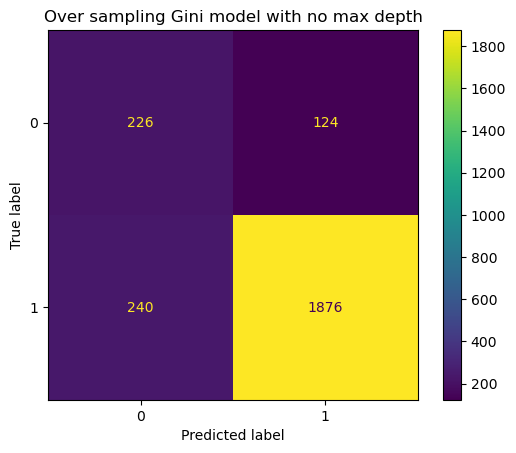

In [43]:
clf = RandomForestClassifier(criterion='gini', random_state=2)
clf.fit(X2_trainOS, y2_trainOS)
y2_pred = clf.predict(X2_test)
print(classification_report(y2_test, y2_pred))
pl = confusion_matrix(y2_test, y2_pred)
disp = ConfusionMatrixDisplay(pl)
disp.plot()
plt.title('Over sampling Gini model with no max depth')
plt.show()

                   precision    recall  f1-score   support

      New_Visitor       0.38      0.77      0.51       350
Returning_Visitor       0.95      0.80      0.87      2116

         accuracy                           0.79      2466
        macro avg       0.67      0.78      0.69      2466
     weighted avg       0.87      0.79      0.82      2466



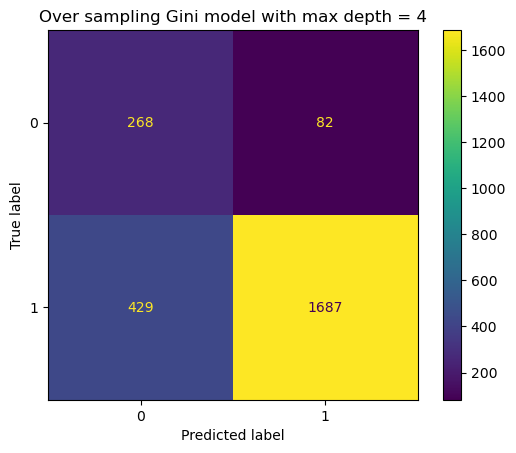

In [44]:
clf = RandomForestClassifier(criterion='gini', max_depth=4, random_state=2)
clf.fit(X2_trainOS, y2_trainOS)
y2_pred = clf.predict(X2_test)
print(classification_report(y2_test, y2_pred))
pl = confusion_matrix(y2_test, y2_pred)
disp = ConfusionMatrixDisplay(pl)
disp.plot()
plt.title('Over sampling Gini model with max depth = 4')
plt.show()

In a similar manner to how the models performed when under sampling, having a specified max depth cut down the false positives by roughly 66%. 

                   precision    recall  f1-score   support

      New_Visitor       0.49      0.65      0.56       350
Returning_Visitor       0.94      0.89      0.91      2116

         accuracy                           0.85      2466
        macro avg       0.72      0.77      0.74      2466
     weighted avg       0.88      0.85      0.86      2466



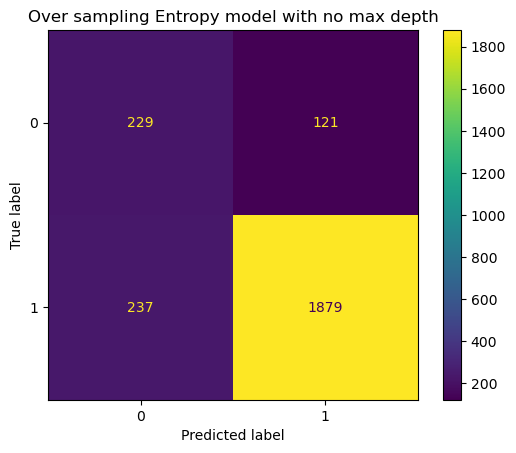

In [45]:
clf = RandomForestClassifier(criterion='entropy', random_state=2)
clf.fit(X2_trainOS, y2_trainOS)
y2_pred = clf.predict(X2_test)
print(classification_report(y2_test, y2_pred))
pl = confusion_matrix(y2_test, y2_pred)
disp = ConfusionMatrixDisplay(pl)
disp.plot()
plt.title('Over sampling Entropy model with no max depth')
plt.show()

                   precision    recall  f1-score   support

      New_Visitor       0.38      0.77      0.51       350
Returning_Visitor       0.95      0.79      0.86      2116

         accuracy                           0.79      2466
        macro avg       0.67      0.78      0.68      2466
     weighted avg       0.87      0.79      0.81      2466



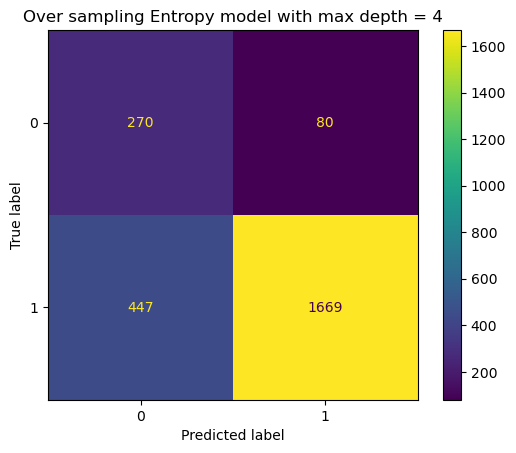

In [46]:
clf = RandomForestClassifier(criterion='entropy', max_depth=4, random_state=2)
clf.fit(X2_trainOS, y2_trainOS)
y2_pred = clf.predict(X2_test)
print(classification_report(y2_test, y2_pred))
pl = confusion_matrix(y2_test, y2_pred)
disp = ConfusionMatrixDisplay(pl)
disp.plot()
plt.title('Over sampling Entropy model with max depth = 4')
plt.show()

The positives in the test dataset were the only ones to undergo a significant change versus the Gini model with the specified max depth. So far both models could work, though I'd lean towards also using Entropy since we're already doing that with the Revenue classification.

                   precision    recall  f1-score   support

      New_Visitor       0.46      0.69      0.55       350
Returning_Visitor       0.94      0.87      0.90      2116

         accuracy                           0.84      2466
        macro avg       0.70      0.78      0.73      2466
     weighted avg       0.88      0.84      0.85      2466



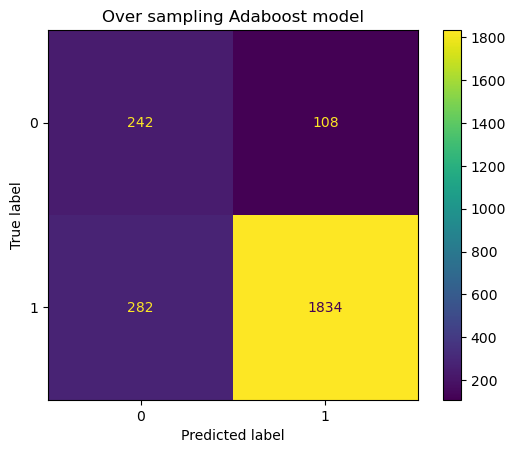

In [47]:
clf = AdaBoostClassifier(n_estimators=100, random_state=3)
clf.fit(X2_trainOS, y2_trainOS)
y2_pred = clf.predict(X2_test)
print(classification_report(y2_test, y2_pred))
pl = confusion_matrix(y2_test, y2_pred)
disp = ConfusionMatrixDisplay(pl)
disp.plot()
plt.title('Over sampling Adaboost model')
plt.show()

                   precision    recall  f1-score   support

      New_Visitor       0.47      0.71      0.57       350
Returning_Visitor       0.95      0.87      0.91      2116

         accuracy                           0.85      2466
        macro avg       0.71      0.79      0.74      2466
     weighted avg       0.88      0.85      0.86      2466



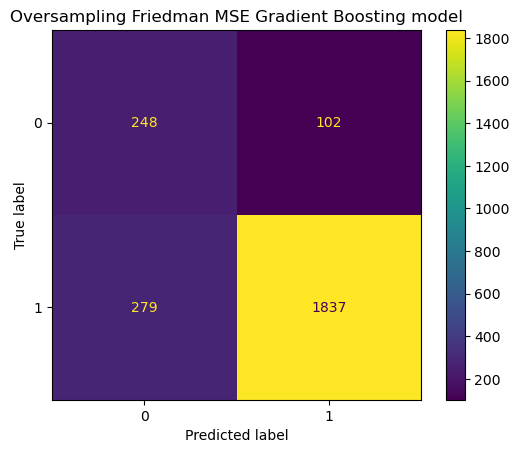

In [48]:
clf = GradientBoostingClassifier(n_estimators=100, criterion='friedman_mse', random_state=4)
clf.fit(X2_trainOS, y2_trainOS)
y2_pred = clf.predict(X2_test)
print(classification_report(y2_test, y2_pred))
pl = confusion_matrix(y2_test, y2_pred)
disp = ConfusionMatrixDisplay(pl)
disp.plot()
plt.title('Oversampling Friedman MSE Gradient Boosting model')
plt.show()

While Gradient Boosting technically did the best here with a recall average of .79, the larger number of false positives compared to the Gini and Entropy models puts me off from choosing it. It's also only better than those two models by .01/.02, which isn't a big enough difference to make it the better choice.  

Once again, to keep things balanced, I used the other classification algorithms like I did with the Revenue classification, and I am...mildly surprised at the results. The average recall of all of the following algorithms is .79. However, the most important number we're looking at is the upper right in the confusion matrix. I visualized them for all of the algorithms below.

                   precision    recall  f1-score   support

      New_Visitor       0.23      0.64      0.34       350
Returning_Visitor       0.92      0.64      0.75      2116

         accuracy                           0.64      2466
        macro avg       0.57      0.64      0.54      2466
     weighted avg       0.82      0.64      0.69      2466



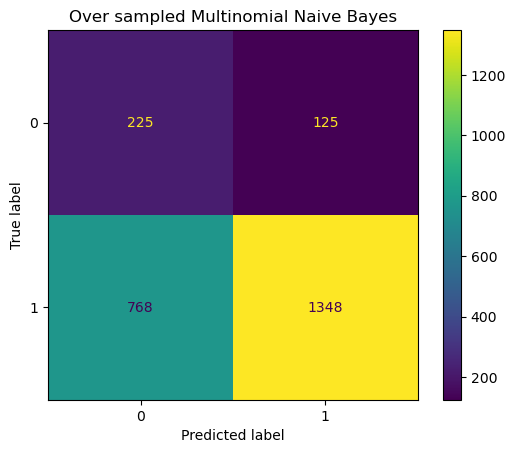

In [64]:
mnb = MultinomialNB().fit(X2_trainOS, y2_trainOS)
y2_pred = mnb.predict(X2_test)
print(classification_report(y2_test, y2_pred))
pl = confusion_matrix(y2_test, y2_pred)
disp = ConfusionMatrixDisplay(pl)
disp.plot()
plt.title('Over sampled Multinomial Naive Bayes')
plt.show()

                   precision    recall  f1-score   support

      New_Visitor       0.30      0.81      0.44       350
Returning_Visitor       0.96      0.69      0.80      2116

         accuracy                           0.70      2466
        macro avg       0.63      0.75      0.62      2466
     weighted avg       0.86      0.70      0.75      2466



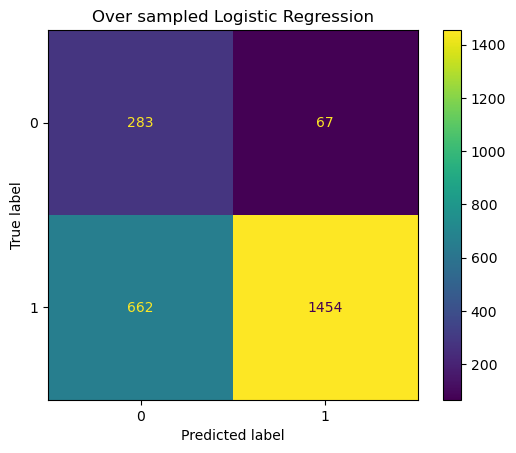

In [65]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X2_trainOS, y2_trainOS)
y2_pred = lr.predict(X2_test)
print(classification_report(y2_test, y2_pred))
pl = confusion_matrix(y2_test, y2_pred)
disp = ConfusionMatrixDisplay(pl)
disp.plot()
plt.title('Over sampled Logistic Regression')
plt.show()

Surprisingly, Logistic Regression lowered the false positives by 16%. If it does well on the under sampling, Logistic Regression may actually be the best algorithm for this task.

                   precision    recall  f1-score   support

      New_Visitor       0.27      0.63      0.37       350
Returning_Visitor       0.92      0.72      0.81      2116

         accuracy                           0.70      2466
        macro avg       0.59      0.67      0.59      2466
     weighted avg       0.83      0.70      0.74      2466



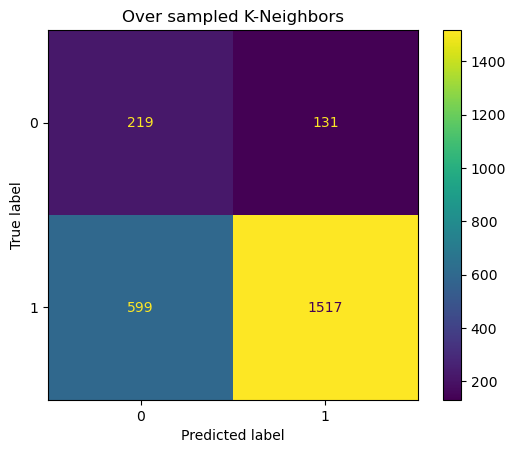

In [66]:
knn = KNeighborsClassifier().fit(X2_trainOS, y2_trainOS)
y2_pred = knn.predict(X2_test)
print(classification_report(y2_test, y2_pred))
pl = confusion_matrix(y2_test, y2_pred)
disp = ConfusionMatrixDisplay(pl)
disp.plot()
plt.title('Over sampled K-Neighbors')
plt.show()

                   precision    recall  f1-score   support

      New_Visitor       0.23      0.63      0.34       350
Returning_Visitor       0.91      0.65      0.76      2116

         accuracy                           0.65      2466
        macro avg       0.57      0.64      0.55      2466
     weighted avg       0.82      0.65      0.70      2466



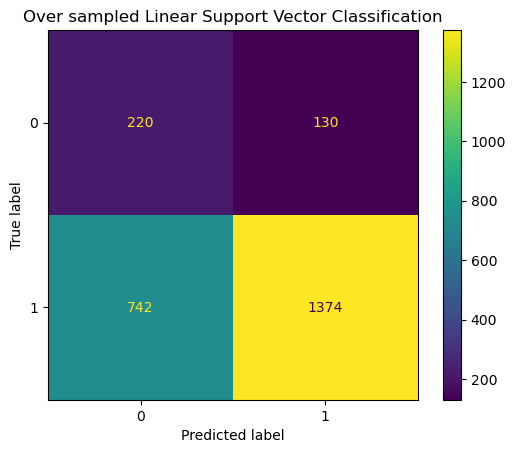

In [67]:
svm = LinearSVC(C=0.0001)
svm.fit(X2_trainOS, y2_trainOS)
y2_pred = svm.predict(X2_test)
print(classification_report(y2_test, y2_pred))
pl = confusion_matrix(y2_test, y2_pred)
disp = ConfusionMatrixDisplay(pl)
disp.plot()
plt.title('Over sampled Linear Support Vector Classification')
plt.show()

Under sampling:

In [53]:
X2_trainUS, y2_trainUS = nm.fit_resample(X2_train, y2_train)

                   precision    recall  f1-score   support

      New_Visitor       0.22      0.82      0.35       350
Returning_Visitor       0.95      0.53      0.68      2116

         accuracy                           0.57      2466
        macro avg       0.59      0.67      0.52      2466
     weighted avg       0.84      0.57      0.63      2466



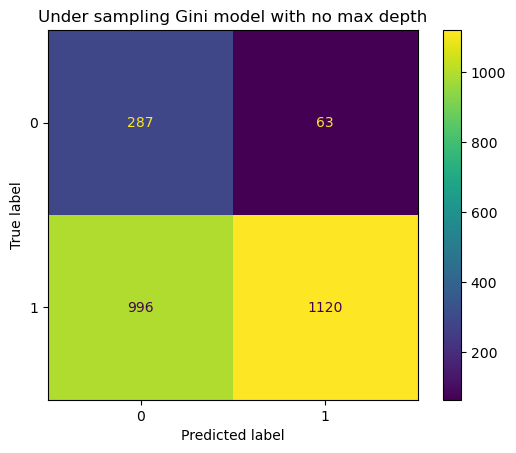

In [54]:
clf = RandomForestClassifier(criterion='gini', random_state=2)
clf.fit(X2_trainUS, y2_trainUS)
y2_pred = clf.predict(X2_test)
print(classification_report(y2_test, y2_pred))
pl = confusion_matrix(y2_test, y2_pred)
disp = ConfusionMatrixDisplay(pl)
disp.plot()
plt.title('Under sampling Gini model with no max depth')
plt.show()

                   precision    recall  f1-score   support

      New_Visitor       0.26      0.80      0.39       350
Returning_Visitor       0.95      0.62      0.75      2116

         accuracy                           0.65      2466
        macro avg       0.60      0.71      0.57      2466
     weighted avg       0.85      0.65      0.70      2466



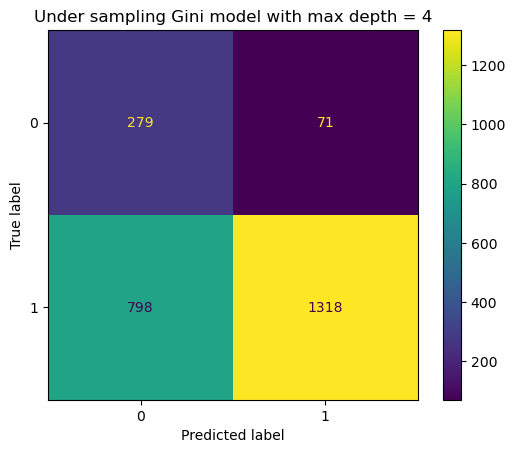

In [55]:
clf = RandomForestClassifier(criterion='gini', max_depth=4, random_state=2)
clf.fit(X2_trainUS, y2_trainUS)
y2_pred = clf.predict(X2_test)
print(classification_report(y2_test, y2_pred))
pl = confusion_matrix(y2_test, y2_pred)
disp = ConfusionMatrixDisplay(pl)
disp.plot()
plt.title('Under sampling Gini model with max depth = 4')
plt.show()

                   precision    recall  f1-score   support

      New_Visitor       0.23      0.82      0.35       350
Returning_Visitor       0.95      0.54      0.68      2116

         accuracy                           0.58      2466
        macro avg       0.59      0.68      0.52      2466
     weighted avg       0.85      0.58      0.64      2466



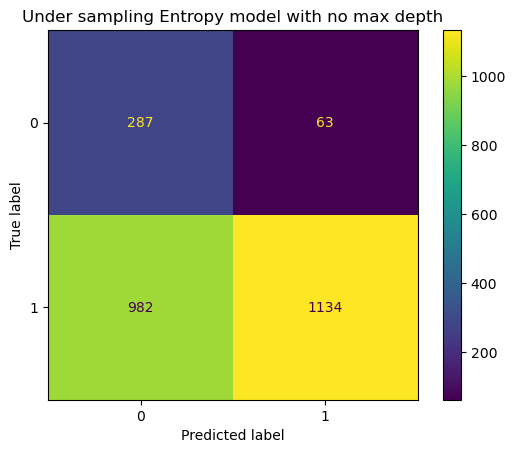

In [56]:
clf = RandomForestClassifier(criterion='entropy', random_state=2)
clf.fit(X2_trainUS, y2_trainUS)
y2_pred = clf.predict(X2_test)
print(classification_report(y2_test, y2_pred))
pl = confusion_matrix(y2_test, y2_pred)
disp = ConfusionMatrixDisplay(pl)
disp.plot()
plt.title('Under sampling Entropy model with no max depth')
plt.show()

                   precision    recall  f1-score   support

      New_Visitor       0.27      0.80      0.40       350
Returning_Visitor       0.95      0.64      0.76      2116

         accuracy                           0.66      2466
        macro avg       0.61      0.72      0.58      2466
     weighted avg       0.85      0.66      0.71      2466



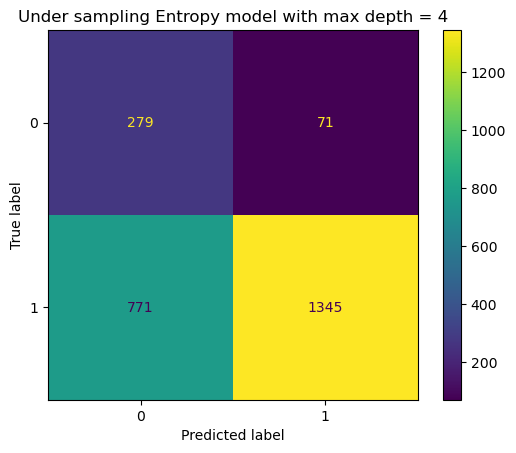

In [57]:
clf = RandomForestClassifier(criterion='entropy', max_depth=4, random_state=2)
clf.fit(X2_trainUS, y2_trainUS)
y2_pred = clf.predict(X2_test)
print(classification_report(y2_test, y2_pred))
pl = confusion_matrix(y2_test, y2_pred)
disp = ConfusionMatrixDisplay(pl)
disp.plot()
plt.title('Under sampling Entropy model with max depth = 4')
plt.show()

The Random Forests are at it again, keeping the false positives very low even while they overfit on the specified depth. I'm looking forward to seeing how Logistic Regression fares.

                   precision    recall  f1-score   support

      New_Visitor       0.19      0.80      0.30       350
Returning_Visitor       0.93      0.43      0.59      2116

         accuracy                           0.48      2466
        macro avg       0.56      0.61      0.45      2466
     weighted avg       0.82      0.48      0.55      2466



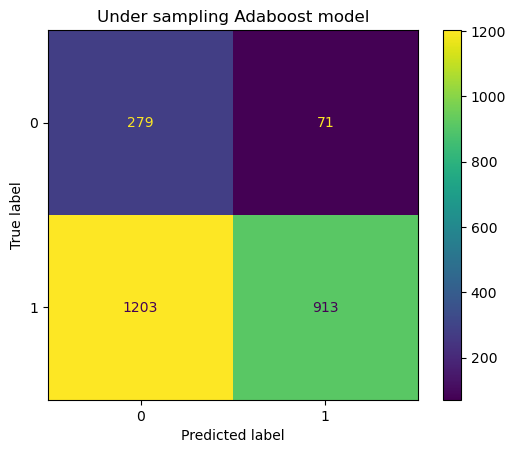

In [58]:
clf = AdaBoostClassifier(n_estimators=100, random_state=3)
clf.fit(X2_trainUS, y2_trainUS)
y2_pred = clf.predict(X2_test)
print(classification_report(y2_test, y2_pred))
pl = confusion_matrix(y2_test, y2_pred)
disp = ConfusionMatrixDisplay(pl)
disp.plot()
plt.title('Under sampling Adaboost model')
plt.show()

                   precision    recall  f1-score   support

      New_Visitor       0.21      0.80      0.34       350
Returning_Visitor       0.94      0.51      0.66      2116

         accuracy                           0.55      2466
        macro avg       0.58      0.66      0.50      2466
     weighted avg       0.84      0.55      0.62      2466



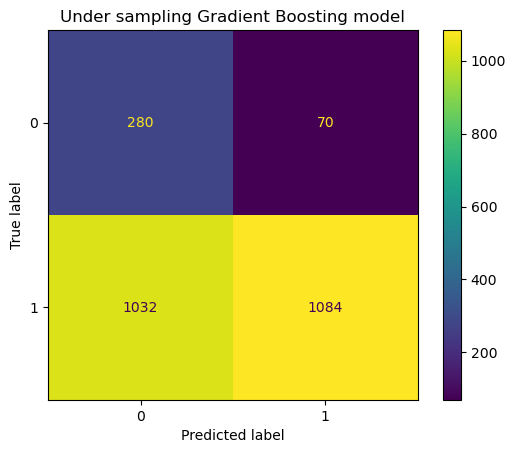

In [59]:
clf = GradientBoostingClassifier(n_estimators=100, criterion='friedman_mse', random_state=4)
clf.fit(X2_trainUS, y2_trainUS)
y2_pred = clf.predict(X2_test)
print(classification_report(y2_test, y2_pred))
pl = confusion_matrix(y2_test, y2_pred)
disp = ConfusionMatrixDisplay(pl)
disp.plot()
plt.title('Under sampling Gradient Boosting model')
plt.show()

The boosting models were on par with the overfitted Random Forests, but because of their performance with the over sampling it wasn't likely they were going to be picked anyway.

                   precision    recall  f1-score   support

      New_Visitor       0.16      0.48      0.24       350
Returning_Visitor       0.87      0.58      0.70      2116

         accuracy                           0.57      2466
        macro avg       0.51      0.53      0.47      2466
     weighted avg       0.77      0.57      0.63      2466



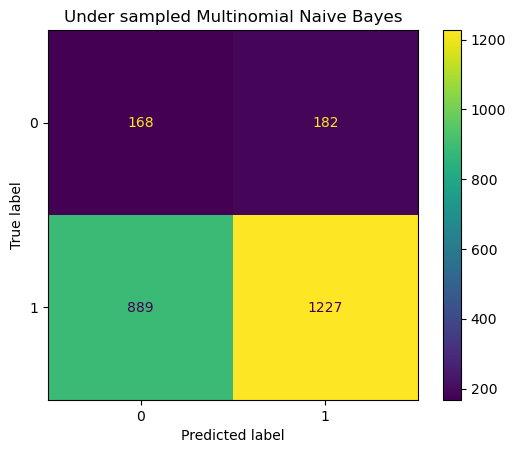

In [68]:
mnb = MultinomialNB().fit(X2_trainUS, y2_trainUS)
y2_pred = mnb.predict(X2_test)
print(classification_report(y2_test, y2_pred))
pl = confusion_matrix(y2_test, y2_pred)
disp = ConfusionMatrixDisplay(pl)
disp.plot()
plt.title('Under sampled Multinomial Naive Bayes')
plt.show()

                   precision    recall  f1-score   support

      New_Visitor       0.16      0.68      0.25       350
Returning_Visitor       0.88      0.39      0.54      2116

         accuracy                           0.43      2466
        macro avg       0.52      0.53      0.40      2466
     weighted avg       0.78      0.43      0.50      2466



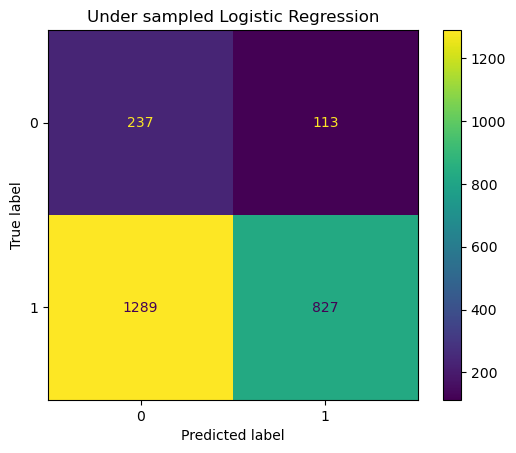

In [69]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X2_trainUS, y2_trainUS)
y2_pred = lr.predict(X2_test)
print(classification_report(y2_test, y2_pred))
pl = confusion_matrix(y2_test, y2_pred)
disp = ConfusionMatrixDisplay(pl)
disp.plot()
plt.title('Under sampled Logistic Regression')
plt.show()

Unfortunate...it looks like Logistic Regression couldn't adapt to the small amount of data. It looked very promising during the over sampling, which goes to show it is worth it to test the algorithms with a lack of data.

                   precision    recall  f1-score   support

      New_Visitor       0.17      0.63      0.26       350
Returning_Visitor       0.89      0.48      0.62      2116

         accuracy                           0.50      2466
        macro avg       0.53      0.55      0.44      2466
     weighted avg       0.78      0.50      0.57      2466



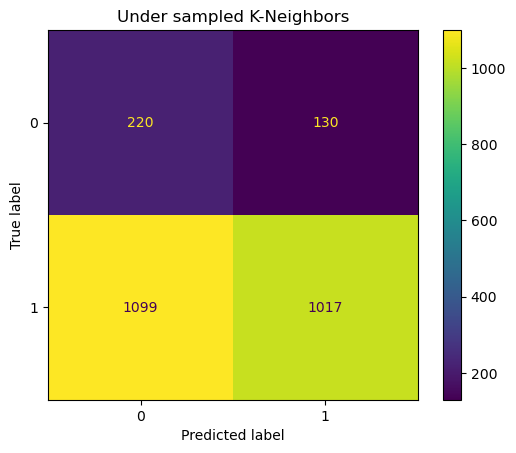

In [70]:
knn = KNeighborsClassifier().fit(X2_trainUS, y2_trainUS)
y2_pred = knn.predict(X2_test)
print(classification_report(y2_test, y2_pred))
pl = confusion_matrix(y2_test, y2_pred)
disp = ConfusionMatrixDisplay(pl)
disp.plot()
plt.title('Under sampled K-Neighbors')
plt.show()

                   precision    recall  f1-score   support

      New_Visitor       0.16      0.71      0.26       350
Returning_Visitor       0.88      0.36      0.52      2116

         accuracy                           0.41      2466
        macro avg       0.52      0.54      0.39      2466
     weighted avg       0.78      0.41      0.48      2466



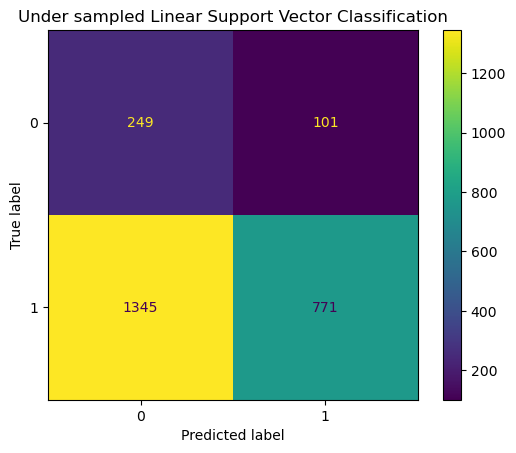

In [71]:
svm = LinearSVC(C=0.0001)
svm.fit(X2_trainUS, y2_trainUS)
y2_pred = svm.predict(X2_test)
print(classification_report(y2_test, y2_pred))
pl = confusion_matrix(y2_test, y2_pred)
disp = ConfusionMatrixDisplay(pl)
disp.plot()
plt.title('Under sampled Linear Support Vector Classification')
plt.show()

It seems like a lot of data and information to take in, but it can be summed up in one sentence: the Entropy Random Forest performed the best on both Revenue and Visitor Type. I would move forward with that algorithm and tweak the max depth to try and find the optimal number, since they can always be improved upon.